In [21]:
import matplotlib.pyplot as plt
import pandas as pd


# traders
def go_long(cash_balance, btc_units, btc_close, long_position, transaction_fee, rf, date):
    # first update cash balance with todays interest
    cash_balance = cash_balance * (1+rf)

    # get the portfolio value
    portfolio_value = cash_balance + btc_units*btc_close

    # we must not be in a position that is not as long as the one we are going into. if not, it is impossible to go long
    current_position = (btc_units*btc_close) / portfolio_value
    if current_position > long_position:
        # print('Could not go Long on ' + str(date))
        return cash_balance, btc_units

    # go long
    target_cash = (1-long_position) * portfolio_value

    # get ammount of cash that can be invested
    cash_to_invest = cash_balance - target_cash

    # secondary checker
    assert cash_to_invest >= 0

    # buy btc
    btc_to_buy = (cash_to_invest / btc_close) * (1-transaction_fee)
    btc_units +=btc_to_buy

    # return new cash balance and btc units in portfolio
    return target_cash, btc_units

def go_short(cash_balance, btc_units, btc_close, short_position, transaction_fee, rf, date):
    
    # first update cash balance
    cash_balance = cash_balance * (1+rf)

    # get the portfolio value
    portfolio_value = cash_balance + btc_units*btc_close

    # we must not be in a position that is as short as the one we are going into. if not, it is impossible to go short
    current_position = (btc_units*btc_close) / portfolio_value
    if current_position < short_position:
        # print('Could not go Short on ' + str(date))
        return cash_balance, btc_units

    # go short
    target_btc_units = (short_position * portfolio_value)/btc_close

    # get ammount of btc to sell (units)
    btc_to_sell = btc_units - target_btc_units
    assert btc_to_sell >= 0

    # calculate cash from selling that many units of btc
    cash_from_sale = btc_to_sell * btc_close * (1-transaction_fee)

    # update cash balance
    cash_balance += cash_from_sale

    return cash_balance, target_btc_units

def hold(cash_balance, rf):

    # add interest 
    cash_balance = cash_balance * (1+rf)

    return cash_balance

def simmulate(
                df : pd.DataFrame, 
                initial_cash : float = 100, 
                long_position : float = 1, 
                short_position : float = 0, 
                transaction_fee : float = 0.001, 
                max_drawdown_threshold : float = 0.4, 
                drawdown_buffer : float = 0.05
              ) -> pd.DataFrame:
    # results
    days = []

    # tracker variables
    cash_balance = 0
    btc_units = initial_cash / df.loc[0, 'Close']

    # btc drawdown helper
    btc_max = df.loc[0, 'Close']

    # portfolio drawdown helper
    portfolio_max = initial_cash

    # drawdown protection helper
    in_drawdown_protection_mode = False

    for i in df.index:
        row = df.iloc[i]
        # initialise day stats
        day ={
            'Date': row['Date']
        }
        # update btc max and keep track of BTC drawdown
        btc_max = max(btc_max, row['Close'])
        day['BTC Drawdown'] = (btc_max - row['Close']) / btc_max

        # get signal
        signal = row['Signal']
        day['Signal'] = signal

        # check if we need to enter drawdown protection mode
        if not in_drawdown_protection_mode and day['BTC Drawdown'] > max_drawdown_threshold:
            in_drawdown_protection_mode = True
            day['Protection Mode'] = True
            # go short
            cash_balance, btc_units = go_short(
                cash_balance = cash_balance, 
                btc_units = btc_units, 
                btc_close = row['Close'], 
                short_position = short_position, 
                transaction_fee = transaction_fee, 
                rf = row['Risk Free Rate'], 
                date = row['Date'])
        
        elif in_drawdown_protection_mode:
            # Case 1 : BTC Drawdown is less than the max drawdown threshold - drawdown buffer so we exit protection mode and go long
            if day['BTC Drawdown'] < (max_drawdown_threshold - drawdown_buffer):
                in_drawdown_protection_mode = False
                day['Protection Mode'] = False

                # go long
                cash_balance, btc_units = go_long(
                    cash_balance = cash_balance, 
                    btc_units = btc_units,
                    btc_close = row['Close'],
                    long_position = long_position,
                    transaction_fee = transaction_fee,
                    rf = row['Risk Free Rate'],
                    date = row['Date'])
                
            else:
                day['Protection Mode'] = True
                cash_balance = hold(cash_balance=cash_balance, rf=row['Risk Free Rate'])
                if signal == 1:  # Buy signal
                    cash_balance, btc_units = go_long(
                        cash_balance=cash_balance, 
                        btc_units=btc_units,
                        btc_close=row['Close'],
                        long_position=long_position,  
                        transaction_fee=transaction_fee,
                        rf=row['Risk Free Rate'],
                        date=row['Date'])
                elif signal == -1:  # Sell signal
                    cash_balance, btc_units = go_short(
                        cash_balance=cash_balance, 
                        btc_units=btc_units, 
                        btc_close=row['Close'], 
                        short_position=short_position,  
                        transaction_fee=transaction_fee, 
                        rf=row['Risk Free Rate'], 
                        date=row['Date'])
                else:  
                    cash_balance = hold(cash_balance=cash_balance, rf=row['Risk Free Rate'])


        


        # if we have to buy we shift to a long position
        elif signal == 1: # buy signal
            in_drawdown_protection_mode = False
            day['Protection Mode'] = in_drawdown_protection_mode
            
            cash_balance, btc_units = go_long(
                cash_balance = cash_balance, 
                btc_units = btc_units, 
                btc_close = row['Close'], 
                long_position = long_position, 
                transaction_fee = transaction_fee, 
                rf = row['Risk Free Rate'], 
                date = row['Date'])    
        # if we have to sell we shift to a short position
        elif signal == -1: # sell signal
            day['Protection Mode'] = False
            cash_balance, btc_units = go_short(
                cash_balance = cash_balance, 
                btc_units = btc_units, 
                btc_close = row['Close'], 
                short_position=short_position, 
                transaction_fee = transaction_fee, 
                rf = row['Risk Free Rate'], 
                date=row['Date'])   
        # if we have to hold, it only affects the cash balance
        elif signal == 0: # hold signal
            day['Protection Mode'] = False
            cash_balance = hold(cash_balance=cash_balance, rf=row['Risk Free Rate'])

        # update balances
        day['Cash Balance'] = cash_balance
        day['BTC Balance'] = btc_units * row['Close']
        day['Portfolio Value'] = day['Cash Balance'] + day['BTC Balance']
        
        # update portfolio max and keep track of portfolio drawdown
        portfolio_max = max(portfolio_max, day['Portfolio Value'])
        day['Portfolio Drawdown'] = (portfolio_max - day['Portfolio Value']) / portfolio_max
        

        days.append(day)

        
    
    days = pd.DataFrame(days)
    # get portfolio value under strategy
    days['Portfolio Value'] = days['Cash Balance'] + days['BTC Balance']
    # get buy and hold portfolio value
    days['Buy and Hold Value'] = (initial_cash / df.loc[0, 'Close']) * df['Close']

    # add risk free rate
    days['Risk Free Rate'] = df['Risk Free Rate']

    return days


# plotters
def plot_portfolio_with_signals(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    plt.figure(figsize=(16, 6))
    plt.plot(df['Date'], df['Portfolio Value'], label='Portfolio Value', color='blue')
    plt.plot(df['Date'], df['Buy and Hold Value'], label='Buy and Hold Value', color='orange')
    
    # Markers for buy/sell signals
    buy_signals = df[df['Signal'] == 1]
    sell_signals = df[df['Signal'] == -1]
    
    plt.scatter(buy_signals['Date'], buy_signals['Portfolio Value'], marker='^', color='green', label='Buy Signal', s=100)
    plt.scatter(sell_signals['Date'], sell_signals['Portfolio Value'], marker='v', color='red', label='Sell Signal', s=100)
    
    plt.title('Portfolio Value Over Time with Buy/Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_drawdown(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    plt.figure(figsize=(16, 4))
    plt.plot(df['Date'], df['BTC Drawdown'], color='orange', label='BTC Drawdown')
    plt.plot(df['Date'], df['Portfolio Drawdown'], color='blue', label='Portfolio Drawdown')
    plt.title('BTC Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_protection_mode(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    plt.figure(figsize=(16, 4))
    plt.plot(df['Date'], df['Protection Mode'], color='red', label='Protection Mode')
    plt.title('Protection Mode Over Time')
    plt.xlabel('Date')
    plt.ylabel('Protection Mode')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# reporter
def generate_report(results, verbose=False):
    # calculate total return
    strategy_total_return = results['Portfolio Value'].iloc[-1] / results['Portfolio Value'].iloc[0]
    buy_and_hold_total_return = results['Buy and Hold Value'].iloc[-1] / results['Buy and Hold Value'].iloc[0]

    strategy_tr_improvement = ((strategy_total_return - buy_and_hold_total_return) / buy_and_hold_total_return) * 100



    # calculate sharpe ratio
    strategy_return = results['Portfolio Value'].pct_change()
    strategy_excess_return = strategy_return - results['Risk Free Rate']
    # annualise the returns
    strategy_excess_return = (1+strategy_excess_return)**365
    strategy_sharpe_ratio = strategy_excess_return.mean() / strategy_excess_return.std()

    buy_and_hold_return = results['Buy and Hold Value'].pct_change()
    buy_and_hold_excess_return = buy_and_hold_return - results['Risk Free Rate']
    # annualise the returns
    buy_and_hold_excess_return = (1+buy_and_hold_excess_return)**365
    buy_and_hold_sharpe_ratio = buy_and_hold_excess_return.mean() / buy_and_hold_excess_return.std()

    strategy_sharpe_improvement = ((strategy_sharpe_ratio - buy_and_hold_sharpe_ratio) / buy_and_hold_sharpe_ratio) * 100



    # calculate max drawdown
    strategy_max_drawdown = results['Portfolio Drawdown'].max()
    buy_and_hold_max_drawdown = results['BTC Drawdown'].max()

    strategy_max_drawdown_improvement = ((strategy_max_drawdown - buy_and_hold_max_drawdown) / buy_and_hold_max_drawdown) * 100



    # signals
    buy_signals = results[results['Signal'] == 1].shape[0]
    sell_signals = results[results['Signal'] == -1].shape[0]
    hold_signals = results[results['Signal'] == 0].shape[0]


    # print a well formatted report
    if verbose:
        print('REPORT')
        print('--------------------------------')
        print(f"Date Range: {results['Date'].iloc[0]} - {results['Date'].iloc[-1]}")
        print('--------------------------------')
        print(f"Strategy Total Return: {strategy_total_return:.2%}")
        print(f"Buy and Hold Total Return: {buy_and_hold_total_return:.2%}")
        print(f"Strategy Improvement (%) : {strategy_tr_improvement:.2f}%")
        print('--------------------------------')
        print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.2f}")
        print(f"Buy and Hold Sharpe Ratio: {buy_and_hold_sharpe_ratio:.2f}")
        print(f"Strategy Improvement (%) : {strategy_sharpe_improvement:.2f}%")
        print('--------------------------------')
        print(f"Strategy Max Drawdown: {strategy_max_drawdown:.2%}")
        print(f"Buy and Hold Max Drawdown: {buy_and_hold_max_drawdown:.2%}")
        print(f"Strategy Improvement (%) : {strategy_max_drawdown_improvement:.2f}%")
        print('--------------------------------')
        print(f'# Buy Signals: {buy_signals}')
        print(f'# Sell Signals: {sell_signals}')
        print(f'# Hold Signals: {hold_signals}')
        print('--------------------------------')

    return {
        'Strategy Total Return': strategy_total_return,
        'Buy and Hold Total Return': buy_and_hold_total_return,
        'Strategy Total Return Improvement': strategy_tr_improvement,
        'Strategy Sharpe Ratio': strategy_sharpe_ratio,
        'Buy and Hold Sharpe Ratio': buy_and_hold_sharpe_ratio,
        'Strategy Sharpe Ratio Improvement': strategy_sharpe_improvement,
        'Strategy Max Drawdown': strategy_max_drawdown,
        'Buy and Hold Max Drawdown': buy_and_hold_max_drawdown,
        'Strategy Max Drawdown Improvement': strategy_max_drawdown_improvement,
        'Buy Signals': buy_signals,
        'Sell Signals': sell_signals,
        'Hold Signals': hold_signals
    }



# Get Signals

In [16]:
from FVG import FVGStrategy

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/Users/hatim/Desktop/Applied Forecasting/Final Project/Algo Trading/data.csv')

rf = df['Risk Free Rate']
btc = df.drop(columns=['Risk Free Rate'])

# strategy = FVGStrategy(lookback_period=10, body_multiplier=1.2, backcandles=50, test_candles=15)
strategy = FVGStrategy(lookback_period=10, body_multiplier=1.5, backcandles=40, test_candles=10)
signals_df = strategy.generate_signals(btc)



signals_df['Risk Free Rate'] = (1 + rf) ** (1/365) - 1
signals_df['Date'] = pd.to_datetime(signals_df['Date'])
signals_df.head()

Detecting Break Signals: 100%|██████████| 3561/3561 [00:00<00:00, 118325.85it/s]

Signal Generation Complete


,Date,Close,Signal,Risk Free Rate
0,2015-07-20,280.00,0,0.000064
1,2015-07-21,277.32,0,0.000063
2,2015-07-22,277.89,0,0.000063
3,2015-07-23,277.39,0,0.000062
4,2015-07-24,289.12,0,0.000062


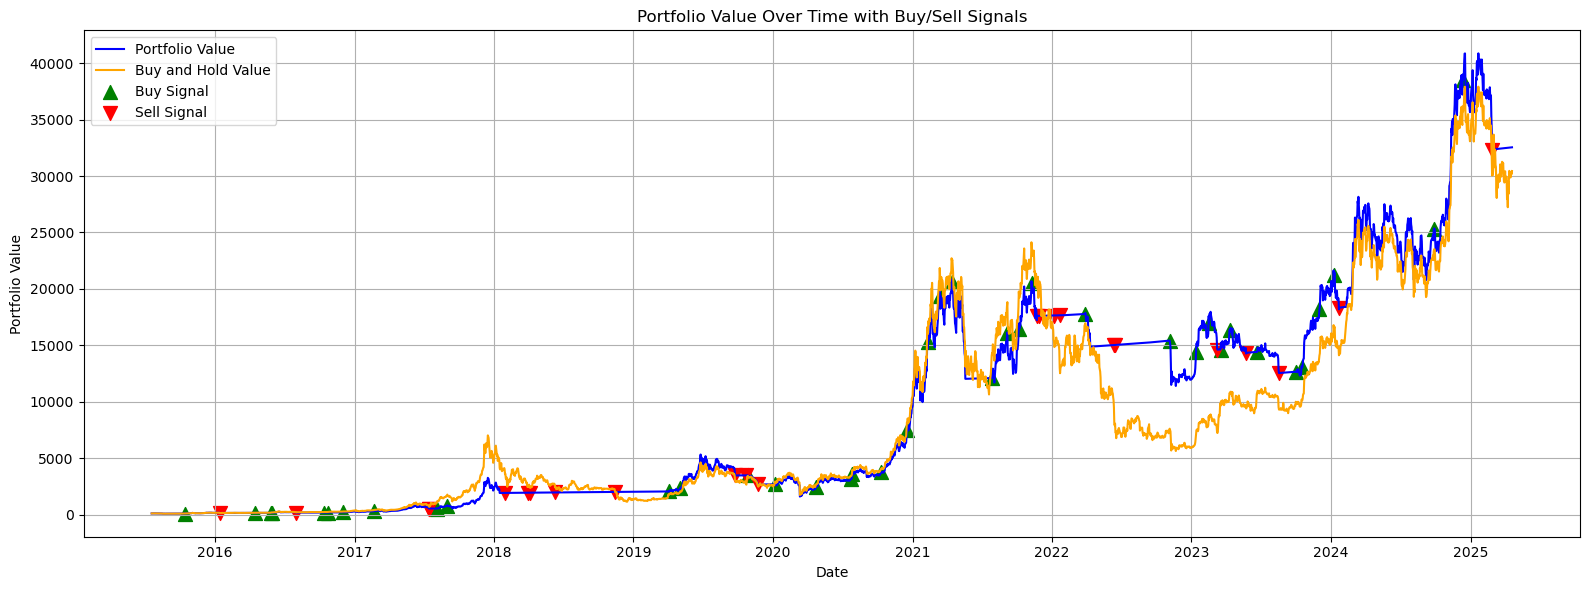

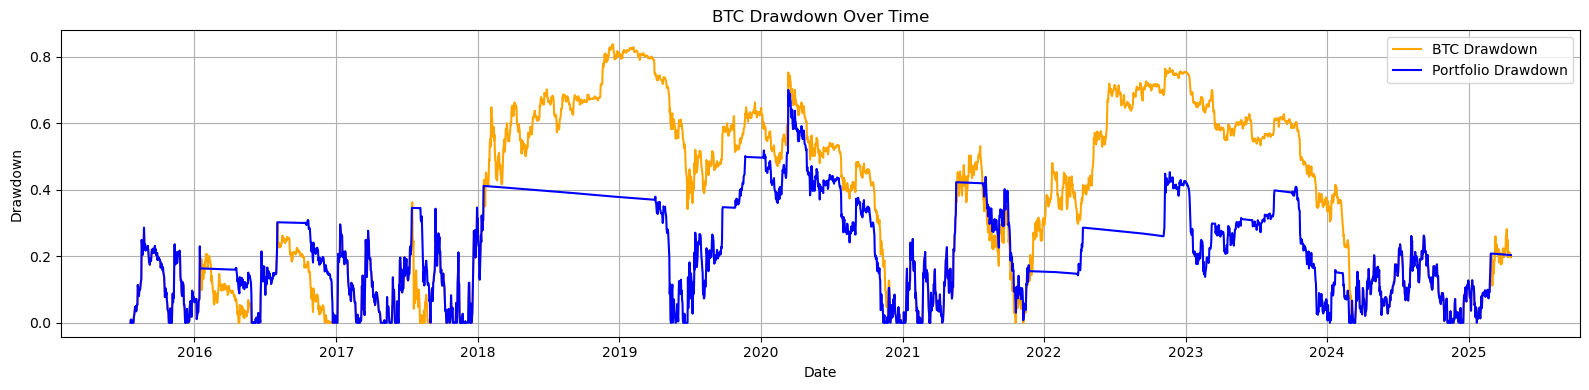

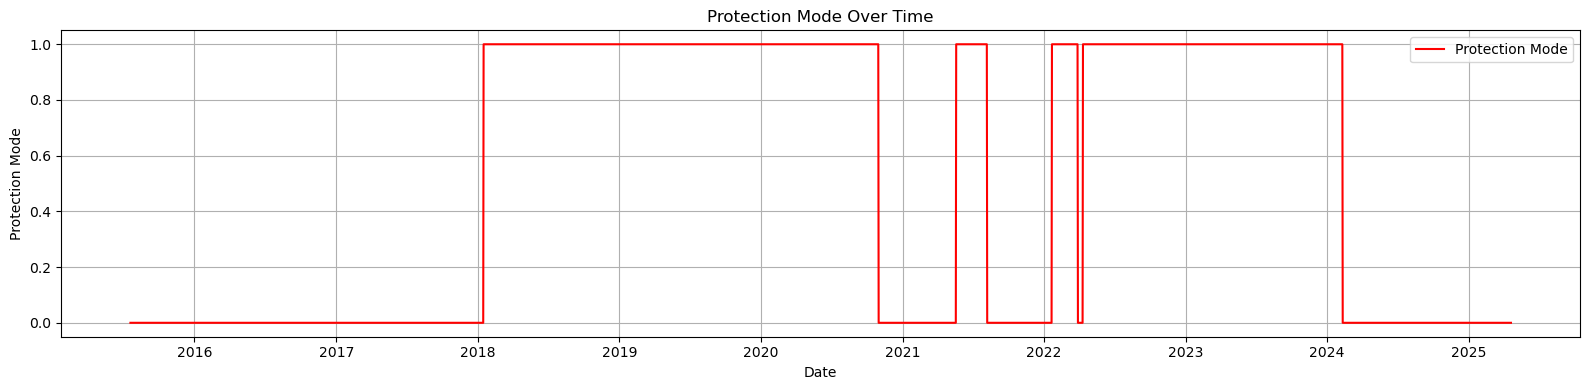

REPORT
--------------------------------
Date Range: 2015-07-20 00:00:00 - 2025-04-19 00:00:00
--------------------------------
Strategy Total Return: 32541.47%
Buy and Hold Total Return: 30441.81%
Strategy Improvement (%) : 6.90%
--------------------------------
Strategy Sharpe Ratio: 0.02
Buy and Hold Sharpe Ratio: 0.02
Strategy Improvement (%) : 0.01%
--------------------------------
Strategy Max Drawdown: 70.07%
Buy and Hold Max Drawdown: 83.80%
Strategy Improvement (%) : -16.39%
--------------------------------
# Buy Signals: 39
# Sell Signals: 23
# Hold Signals: 3500
--------------------------------


In [12]:
result = simmulate(signals_df, max_drawdown_threshold=0.4, drawdown_buffer=0.1)

    # plot results
plot_portfolio_with_signals(result)
plot_drawdown(result)
plot_protection_mode(result)

    # generate report
report = generate_report(result)

In [22]:
import numpy as np
import tqdm
# grid search
results = []


for lookback_period in tqdm.tqdm(np.linspace(10, 100, 10)):
    for body_multiplier in np.linspace(1, 2, 10):
        for backcandles in np.linspace(10, 100, 10):
            for test_candles in np.linspace(1, 10, 1):
                for max_drawdown_threshold in np.linspace(0.2, 0.6, 10):
                    for drawdown_buffer in np.linspace(0.05, 0.2, 10):

                        strategy = FVGStrategy(lookback_period=int(lookback_period), body_multiplier=body_multiplier, backcandles=int(backcandles), test_candles=int(test_candles))
                        signals = strategy.generate_signals(btc)
                        signals['Risk Free Rate'] = (1 + rf) ** (1/365) - 1
                        signals['Date'] = pd.to_datetime(signals['Date'])
                        # simulate
                        result = simmulate(signals, max_drawdown_threshold=max_drawdown_threshold, drawdown_buffer=drawdown_buffer)
                        # generate report
                        report = generate_report(result)
                        # add to results
                        params = {
                            'lookback_period': lookback_period,
                            'body_multiplier': body_multiplier,
                            'backcandles': backcandles,
                            'test_candles': test_candles,
                            'max_drawdown_threshold': max_drawdown_threshold,
                            'drawdown_buffer': drawdown_buffer,
                            **report
                        }
                        results.append(params)
                        
    #                     # jump out of all loops
    #                     break
    #                 break
    #             break
    #         break
    #     break
    # break


results = pd.DataFrame(results)
results
                

  0%|          | 0/10 [00:02<?, ?it/s]

Signal Generation Complete


,lookback_period,body_multiplier,backcandles,test_candles,max_drawdown_threshold,drawdown_buffer,Strategy Total Return,Buy and Hold Total Return,Strategy Total Return Improvement,Strategy Sharpe Ratio,Buy and Hold Sharpe Ratio,Strategy Sharpe Ratio Improvement,Strategy Max Drawdown,Buy and Hold Max Drawdown,Strategy Max Drawdown Improvement,Buy Signals,Sell Signals,Hold Signals
0,10.0,1.0,10.0,1.0,0.2,0.05,101.864183,304.418143,-66.538071,0.016759,0.016758,0.006374,0.580403,0.838015,-30.740758,224,138,3200


# Years

In [5]:
def simulate_for_year(signals_df, year):
    # filter year
    sigs = signals_df[signals_df['Date'].dt.year == year].reset_index(drop=True)

    # run simulation
    result = simmulate(sigs, max_drawdown_threshold=0.4, drawdown_buffer=0.1)

    # plot results
    plot_portfolio_with_signals(result)
    plot_drawdown(result)
    plot_protection_mode(result)

    # generate report
    report = generate_report(result)


## 2015

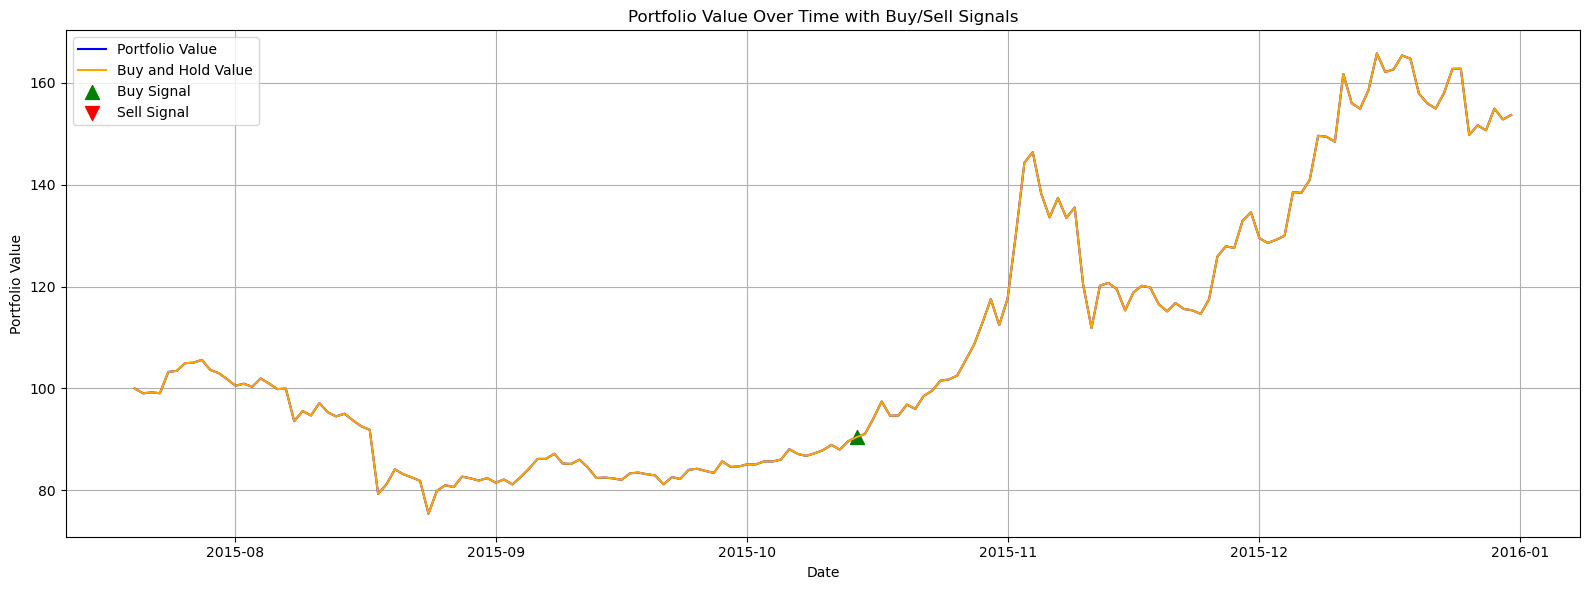

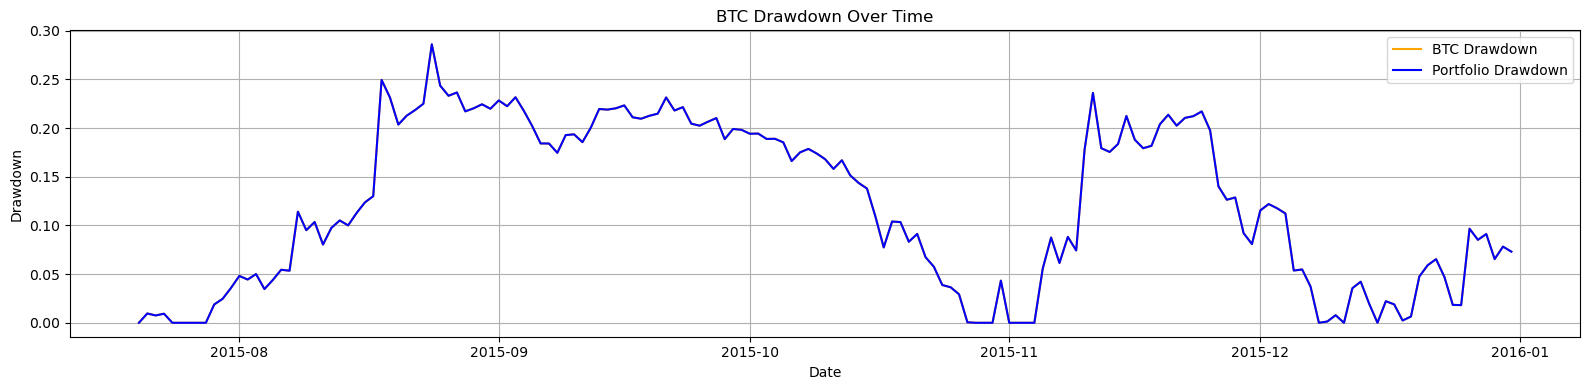

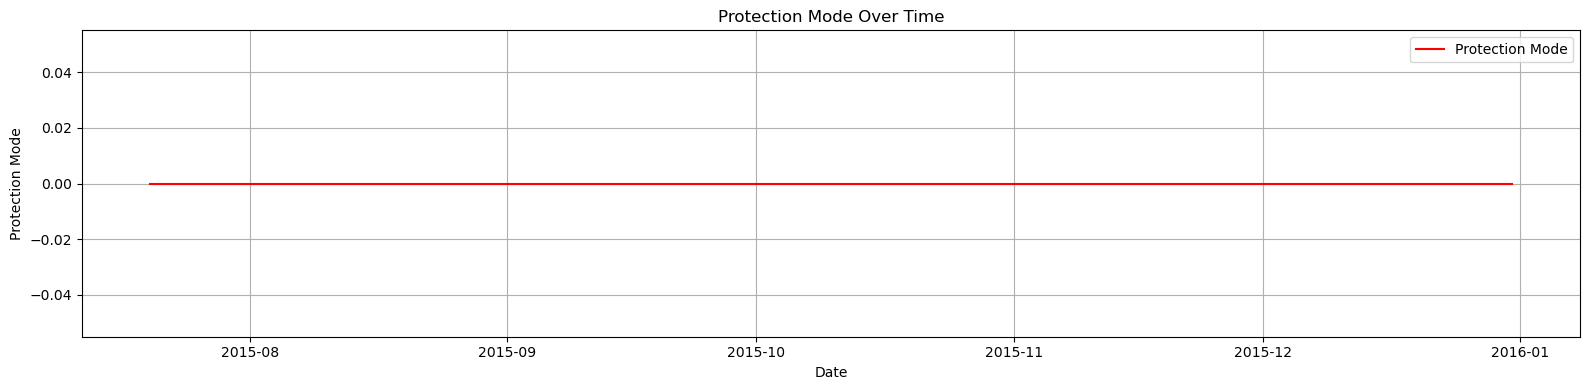

REPORT
--------------------------------
Date Range: 2015-07-20 00:00:00 - 2015-12-31 00:00:00
--------------------------------
Strategy Total Return: 153.70%
Buy and Hold Total Return: 153.70%
Strategy Improvement (%) : 0.00%
--------------------------------
Strategy Sharpe Ratio: 0.11
Buy and Hold Sharpe Ratio: 0.11
Strategy Improvement (%) : 0.00%
--------------------------------
Strategy Max Drawdown: 28.60%
Buy and Hold Max Drawdown: 28.60%
Strategy Improvement (%) : 0.00%
--------------------------------
# Buy Signals: 1
# Sell Signals: 0
# Hold Signals: 164
--------------------------------


In [10]:
simulate_for_year(signals_df, 2015)



## 2016

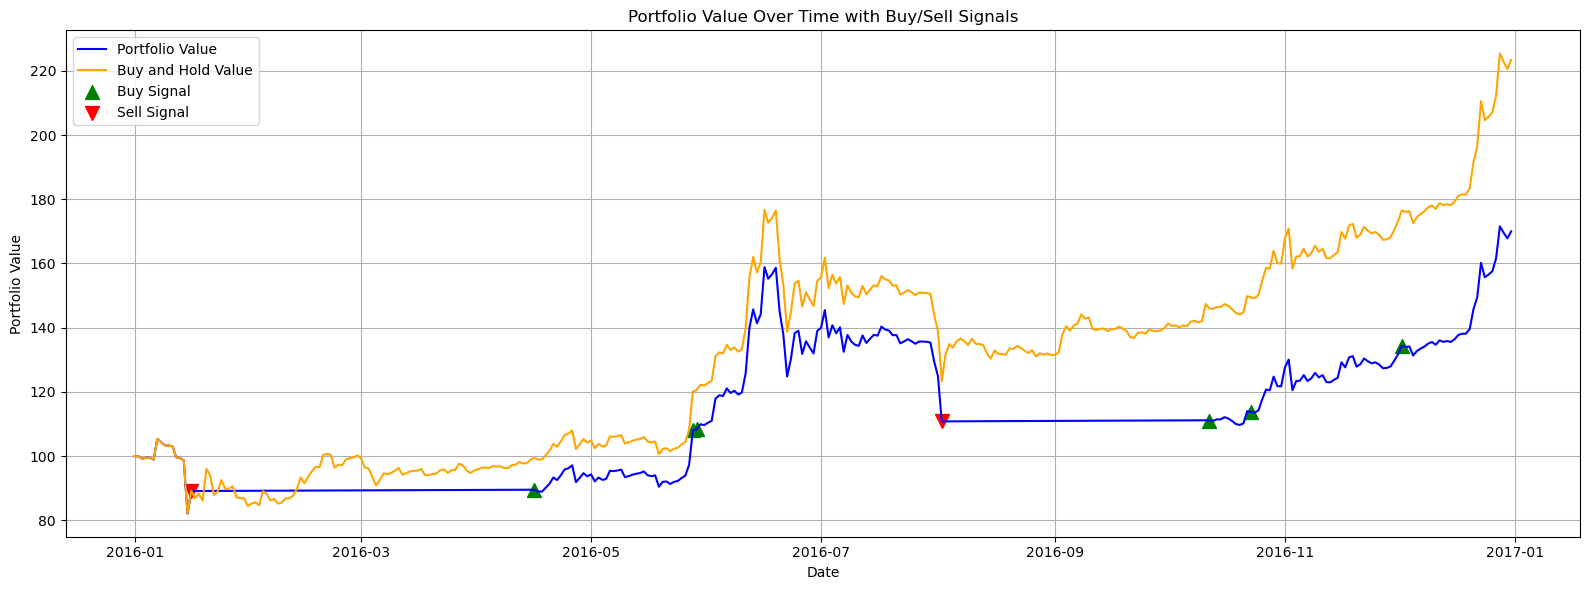

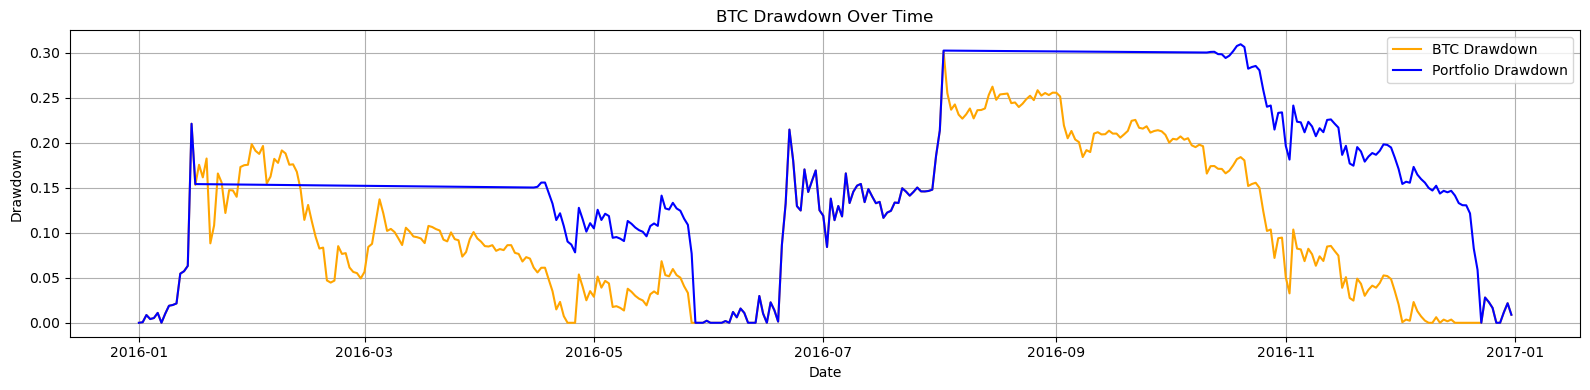

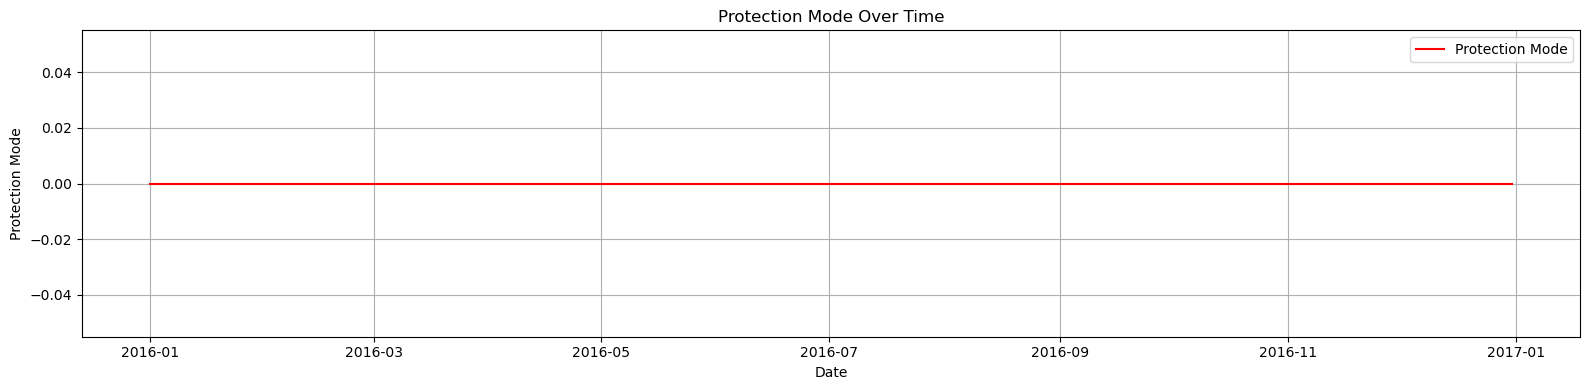

REPORT
--------------------------------
Date Range: 2016-01-01 00:00:00 - 2016-12-31 00:00:00
--------------------------------
Strategy Total Return: 170.02%
Buy and Hold Total Return: 223.42%
Strategy Improvement (%) : -23.90%
--------------------------------
Strategy Sharpe Ratio: 0.07
Buy and Hold Sharpe Ratio: 0.08
Strategy Improvement (%) : -4.52%
--------------------------------
Strategy Max Drawdown: 30.95%
Buy and Hold Max Drawdown: 30.18%
Strategy Improvement (%) : 2.56%
--------------------------------
# Buy Signals: 6
# Sell Signals: 2
# Hold Signals: 358
--------------------------------


In [11]:
simulate_for_year(signals_df, 2016)

## 2017

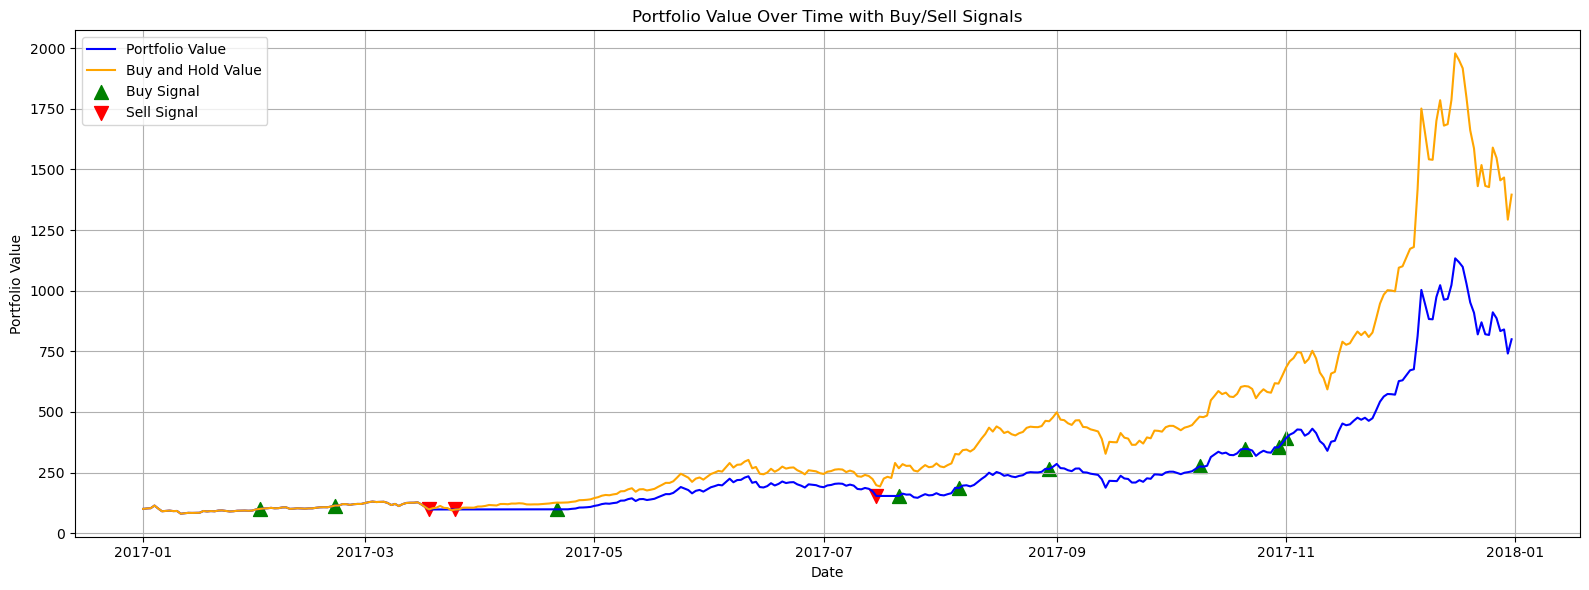

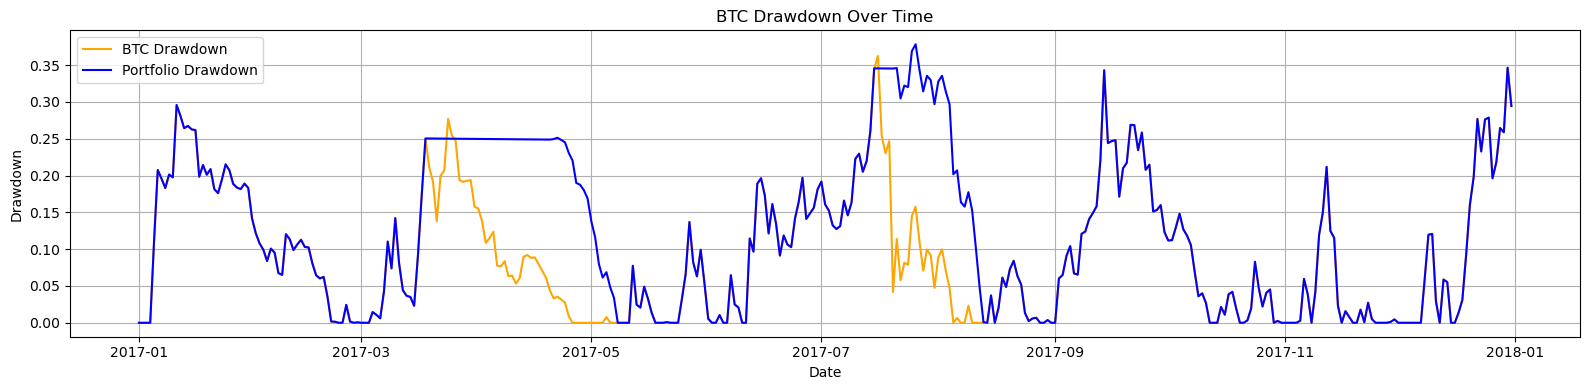

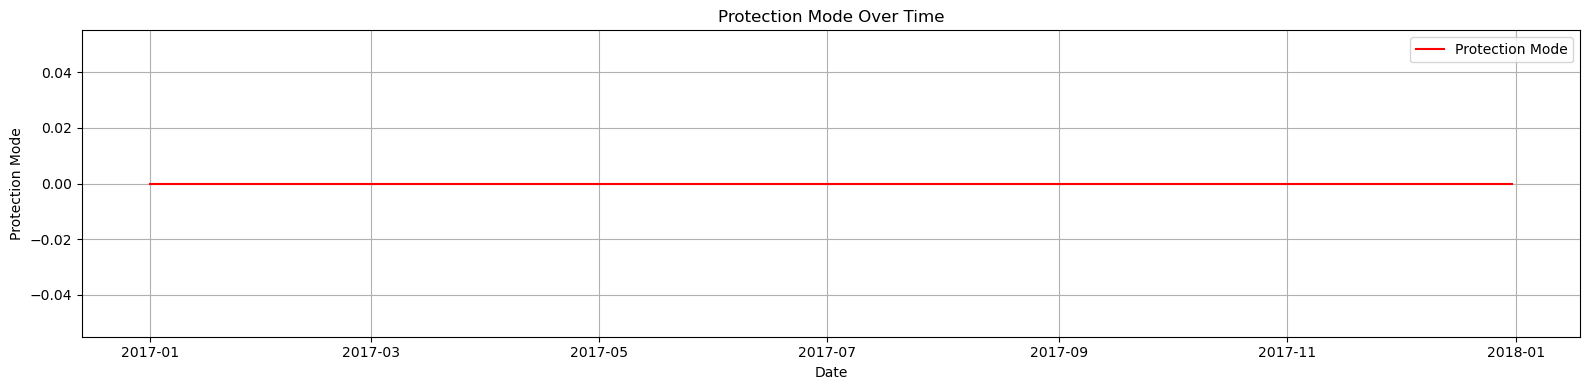

REPORT
--------------------------------
Date Range: 2017-01-01 00:00:00 - 2017-12-31 00:00:00
--------------------------------
Strategy Total Return: 799.66%
Buy and Hold Total Return: 1396.16%
Strategy Improvement (%) : -42.72%
--------------------------------
Strategy Sharpe Ratio: 0.05
Buy and Hold Sharpe Ratio: 0.05
Strategy Improvement (%) : 0.01%
--------------------------------
Strategy Max Drawdown: 37.84%
Buy and Hold Max Drawdown: 36.25%
Strategy Improvement (%) : 4.39%
--------------------------------
# Buy Signals: 10
# Sell Signals: 3
# Hold Signals: 352
--------------------------------


In [8]:
simulate_for_year(signals_df, 2017)

## 2018

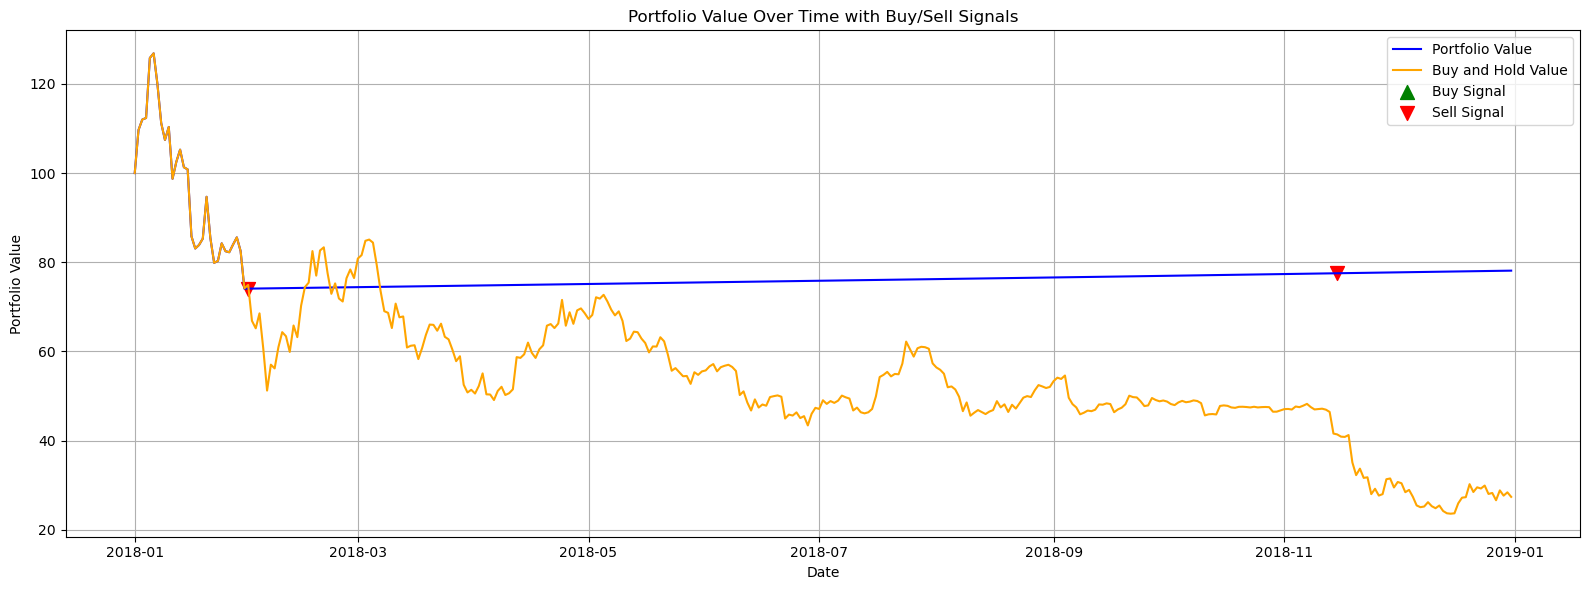

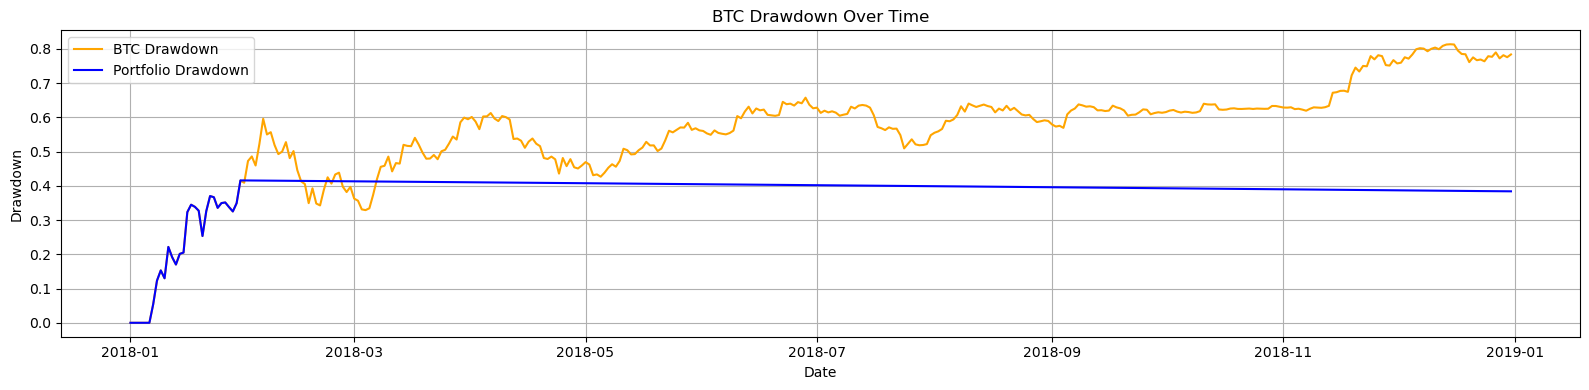

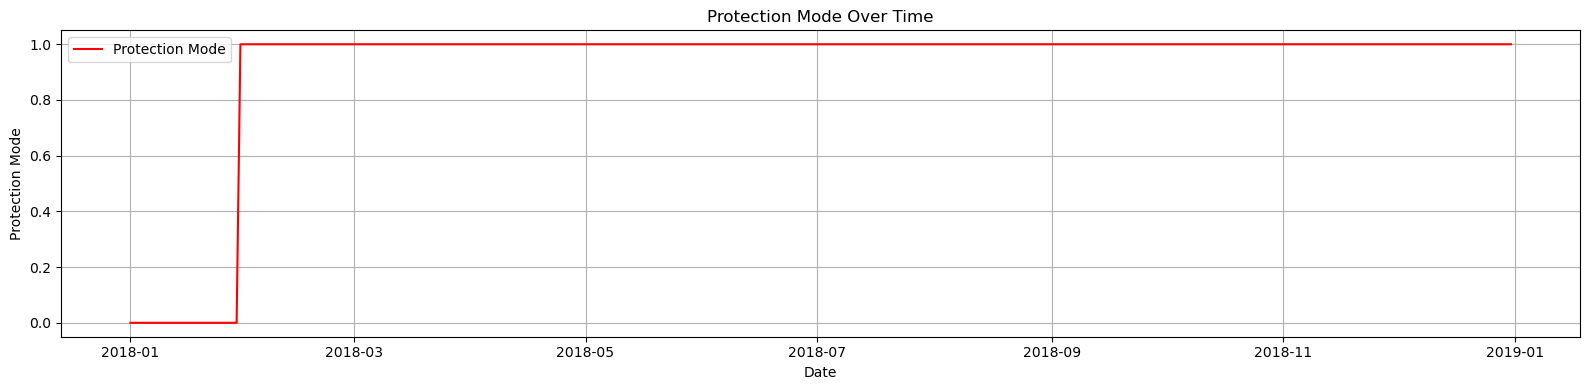

REPORT
--------------------------------
Date Range: 2018-01-01 00:00:00 - 2018-12-31 00:00:00
--------------------------------
Strategy Total Return: 78.12%
Buy and Hold Total Return: 27.39%
Strategy Improvement (%) : 185.23%
--------------------------------
Strategy Sharpe Ratio: 0.05
Buy and Hold Sharpe Ratio: 0.05
Strategy Improvement (%) : 3.53%
--------------------------------
Strategy Max Drawdown: 41.60%
Buy and Hold Max Drawdown: 81.38%
Strategy Improvement (%) : -48.88%
--------------------------------
# Buy Signals: 0
# Sell Signals: 2
# Hold Signals: 363
--------------------------------


: 

: 

In [16]:
simulate_for_year(signals_df, 2018)

## 2019

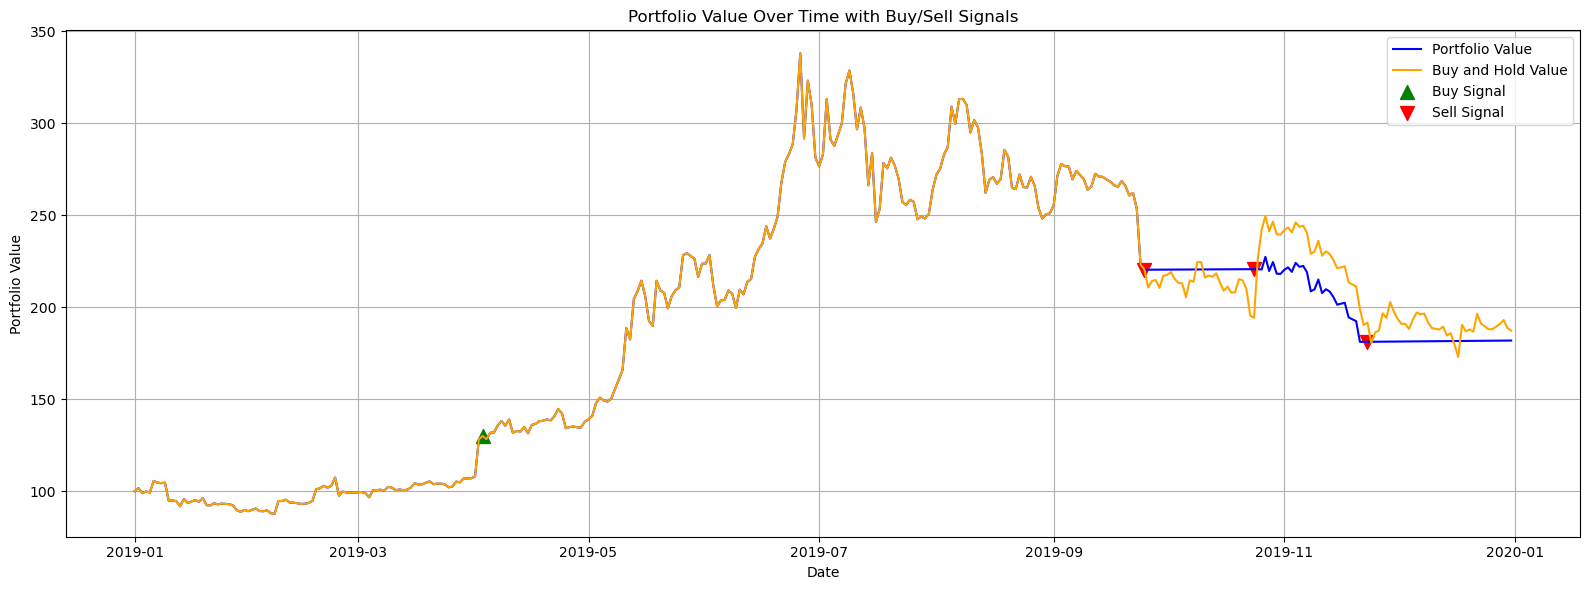

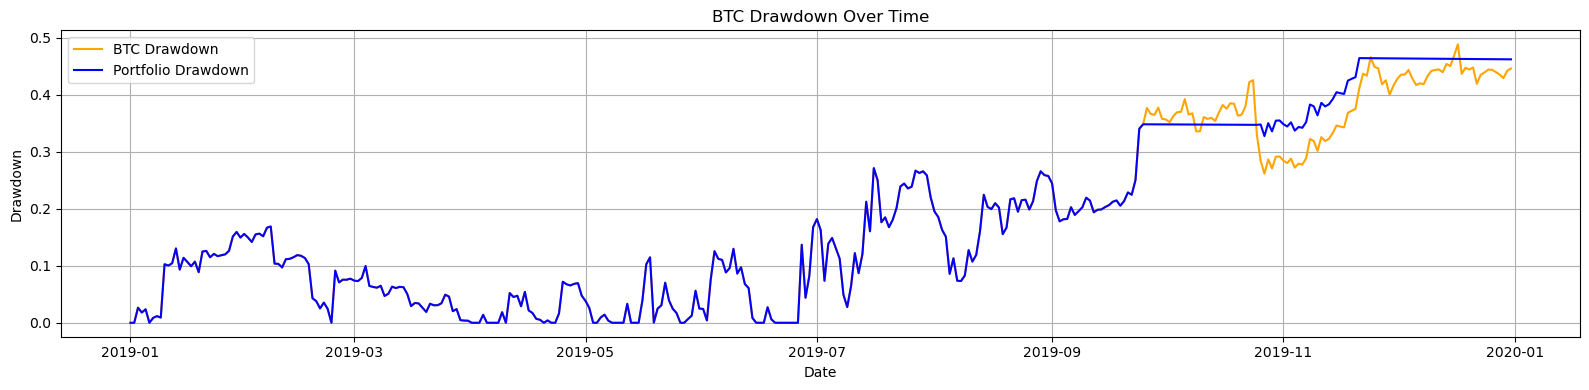

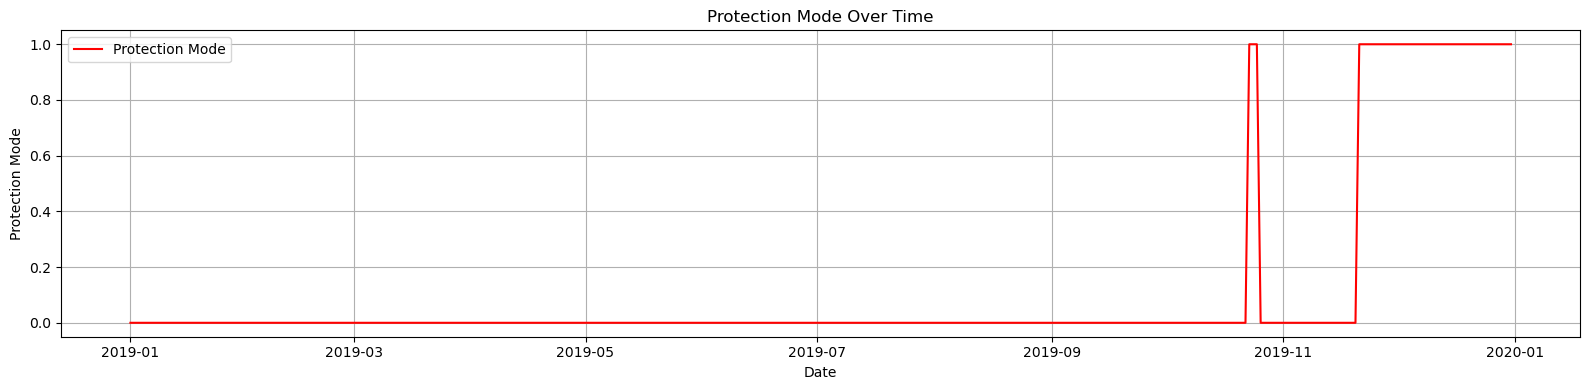

REPORT
--------------------------------
Date Range: 2019-01-01 00:00:00 - 2019-12-31 00:00:00
--------------------------------
Strategy Total Return: 181.86%
Buy and Hold Total Return: 187.29%
Strategy Improvement (%) : -2.90%
--------------------------------
Strategy Sharpe Ratio: 0.05
Buy and Hold Sharpe Ratio: 0.05
Strategy Improvement (%) : -0.33%
--------------------------------
Strategy Max Drawdown: 46.39%
Buy and Hold Max Drawdown: 48.82%
Strategy Improvement (%) : -4.97%
--------------------------------
# Buy Signals: 1
# Sell Signals: 3
# Hold Signals: 361
--------------------------------


: 

: 

In [17]:
simulate_for_year(signals_df, 2019)

## 2020

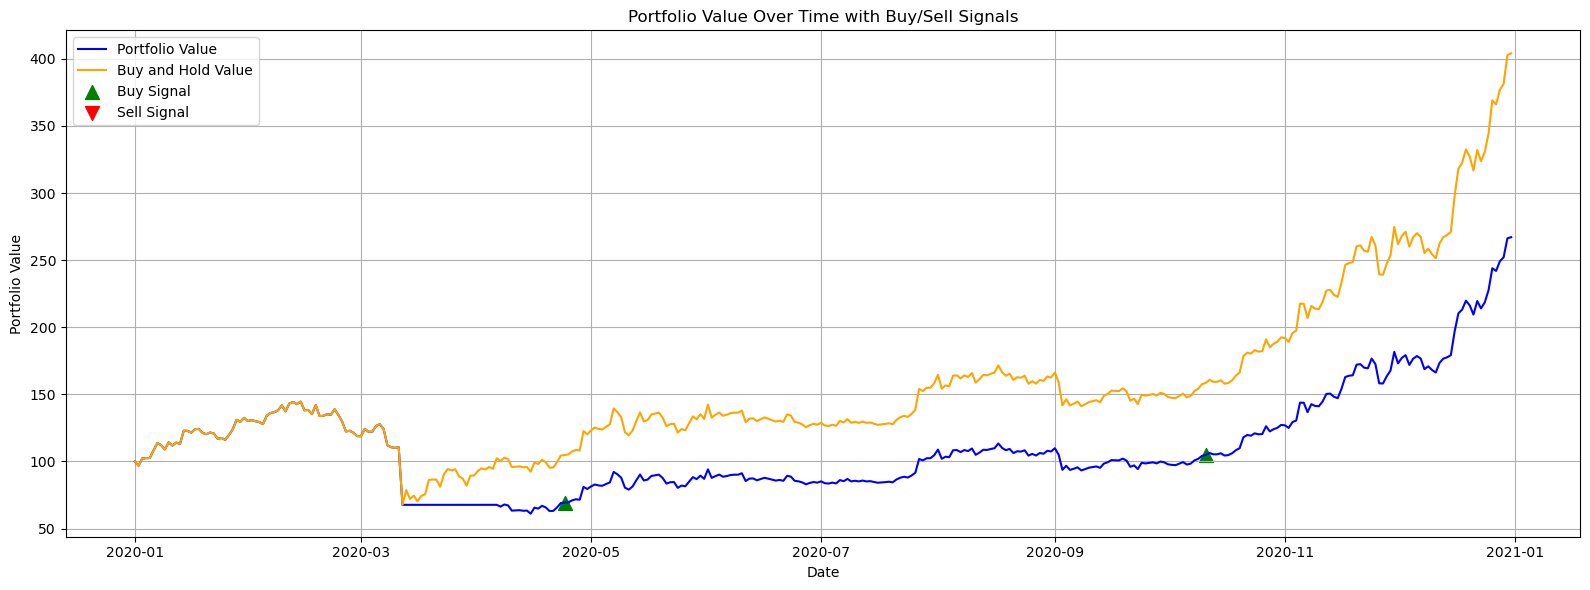

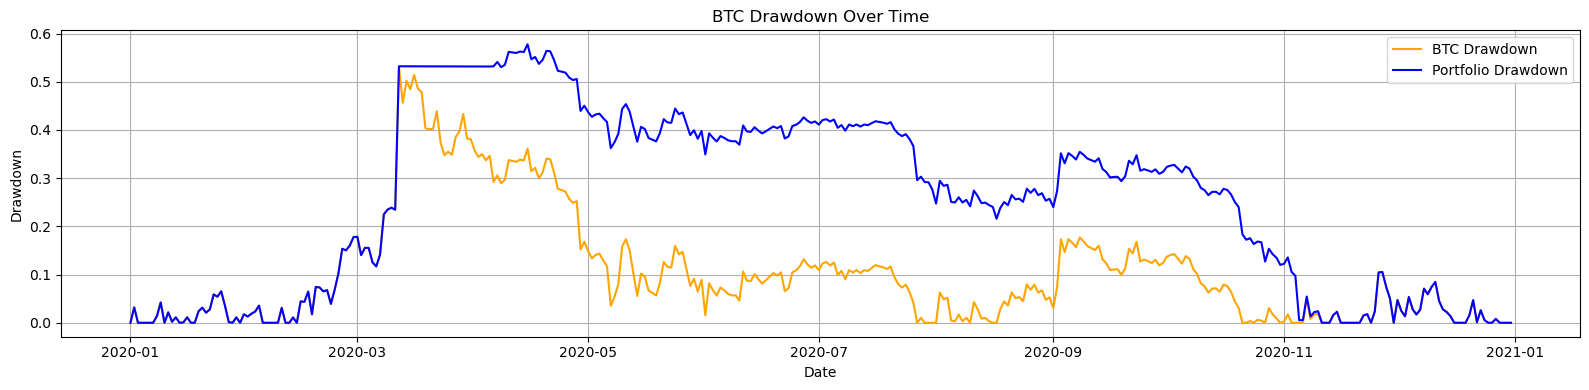

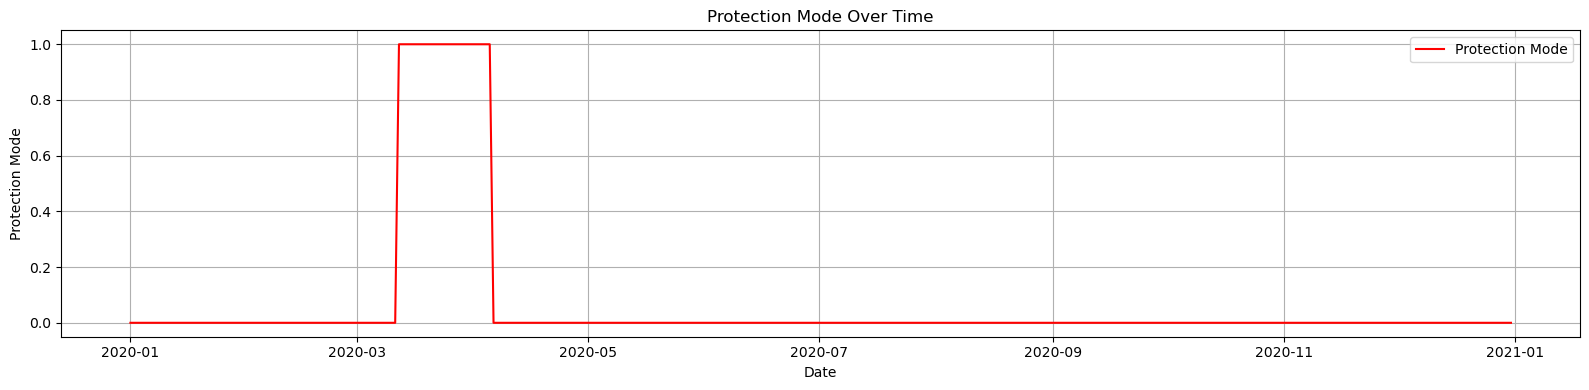

REPORT
--------------------------------
Date Range: 2020-01-01 00:00:00 - 2020-12-31 00:00:00
--------------------------------
Strategy Total Return: 267.09%
Buy and Hold Total Return: 404.08%
Strategy Improvement (%) : -33.90%
--------------------------------
Strategy Sharpe Ratio: 0.05
Buy and Hold Sharpe Ratio: 0.05
Strategy Improvement (%) : -0.28%
--------------------------------
Strategy Max Drawdown: 57.78%
Buy and Hold Max Drawdown: 53.17%
Strategy Improvement (%) : 8.68%
--------------------------------
# Buy Signals: 2
# Sell Signals: 0
# Hold Signals: 364
--------------------------------


: 

: 

In [18]:
simulate_for_year(signals_df, 2020)

## 2021

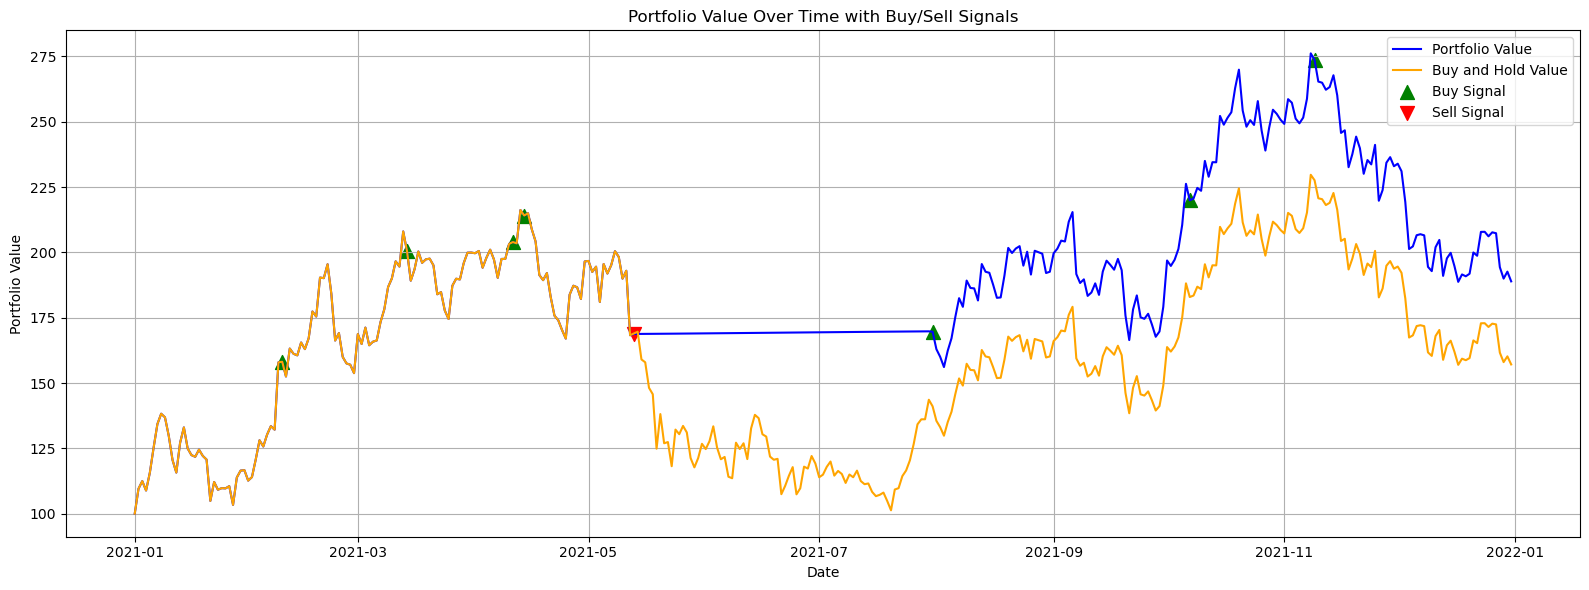

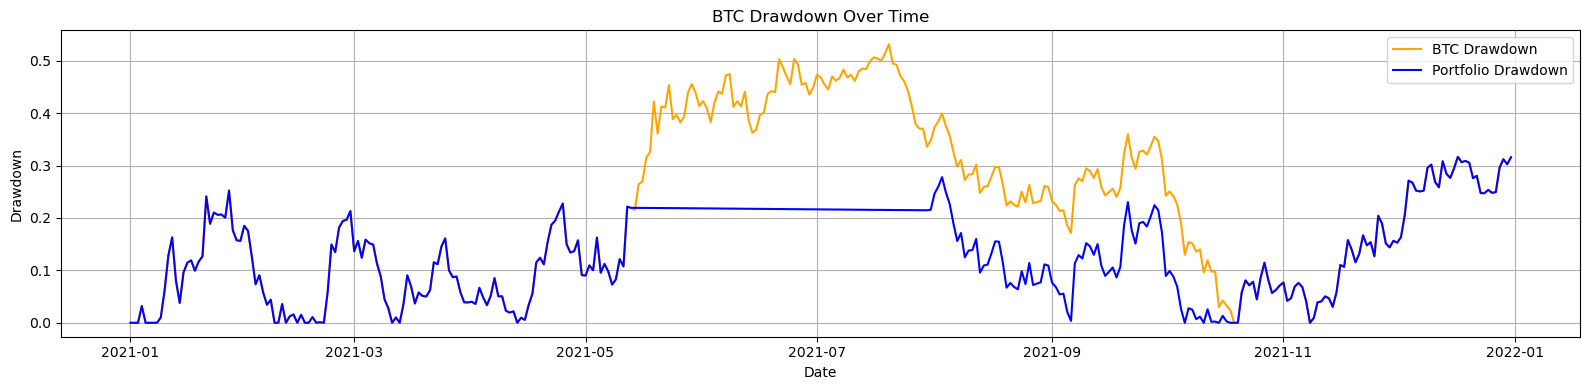

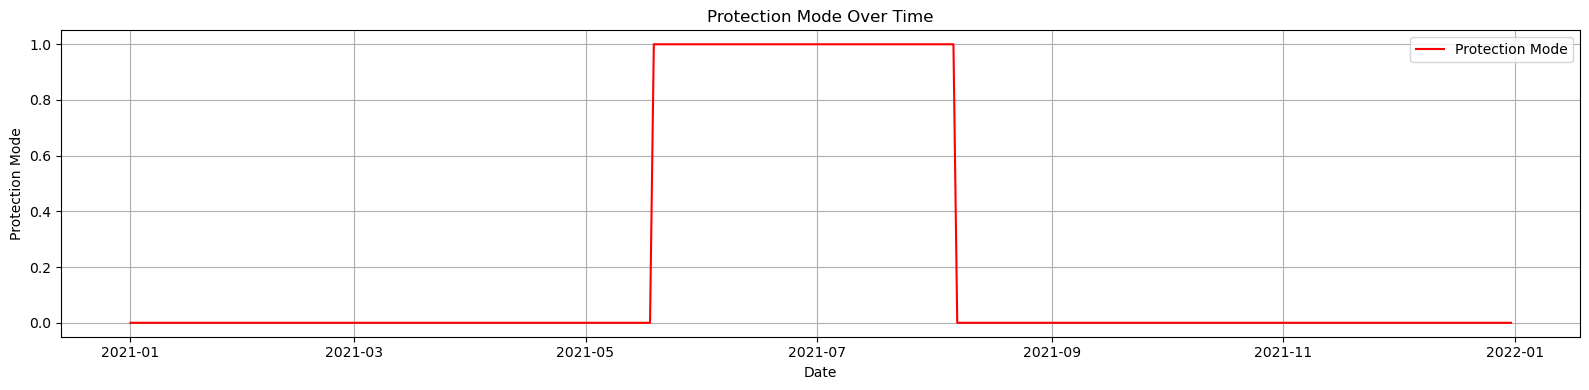

REPORT
--------------------------------
Date Range: 2021-01-01 00:00:00 - 2021-12-31 00:00:00
--------------------------------
Strategy Total Return: 188.90%
Buy and Hold Total Return: 157.11%
Strategy Improvement (%) : 20.23%
--------------------------------
Strategy Sharpe Ratio: 0.05
Buy and Hold Sharpe Ratio: 0.05
Strategy Improvement (%) : -0.00%
--------------------------------
Strategy Max Drawdown: 31.66%
Buy and Hold Max Drawdown: 53.14%
Strategy Improvement (%) : -40.42%
--------------------------------
# Buy Signals: 7
# Sell Signals: 1
# Hold Signals: 357
--------------------------------


: 

: 

In [19]:
simulate_for_year(signals_df, 2021)

## 2022

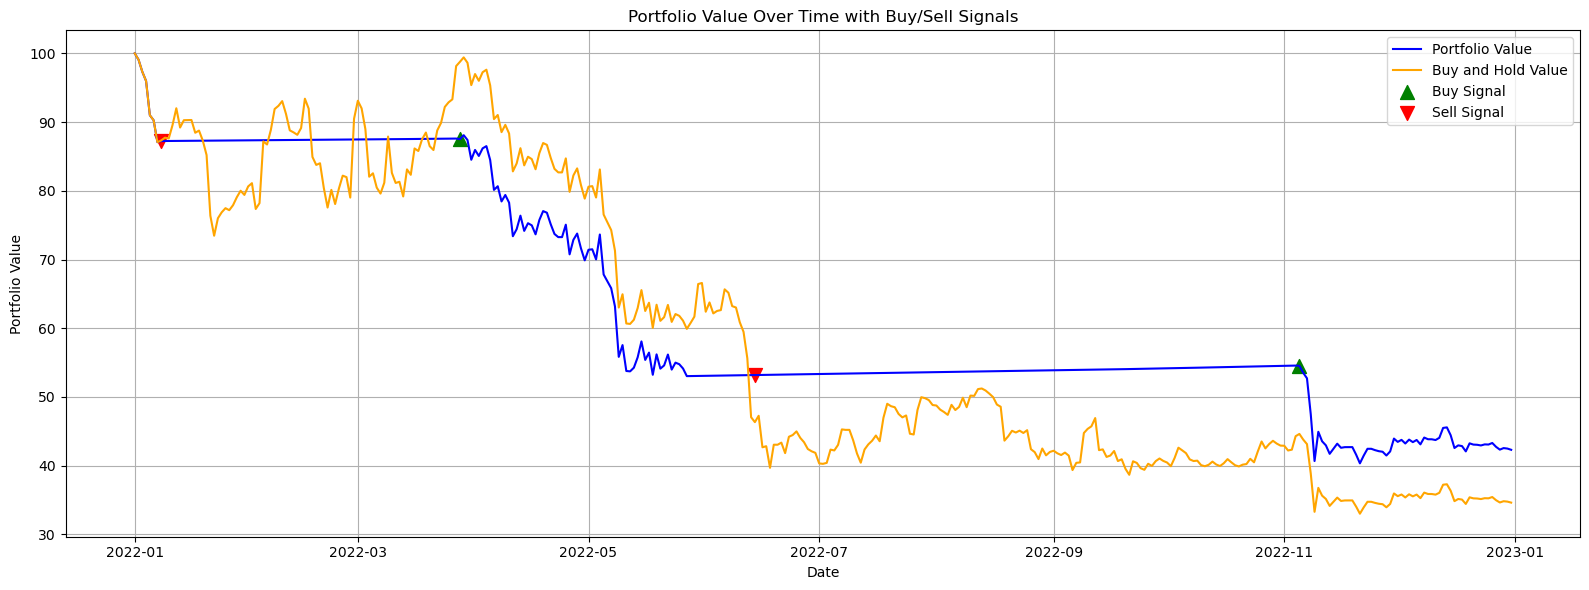

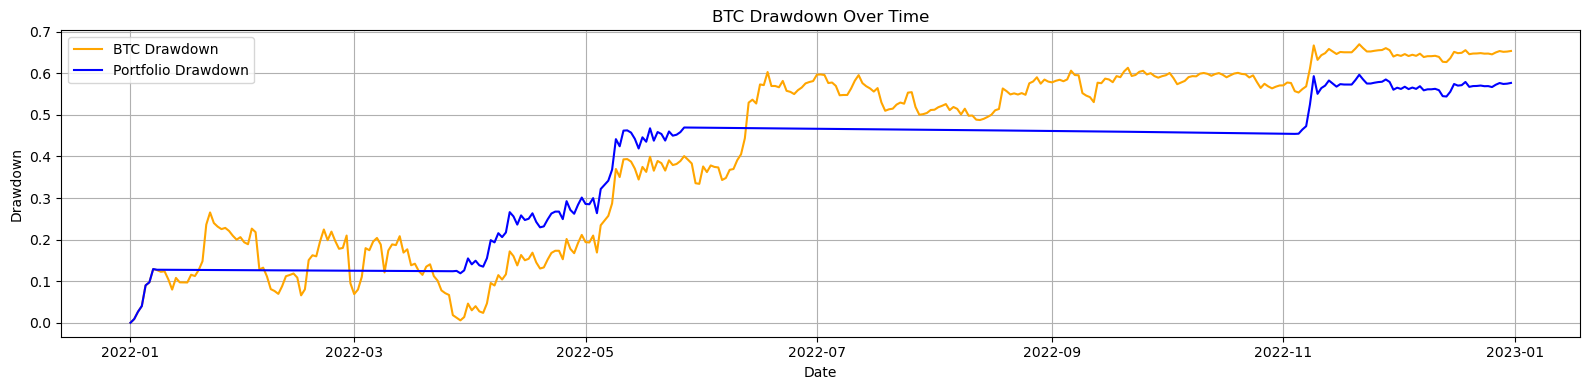

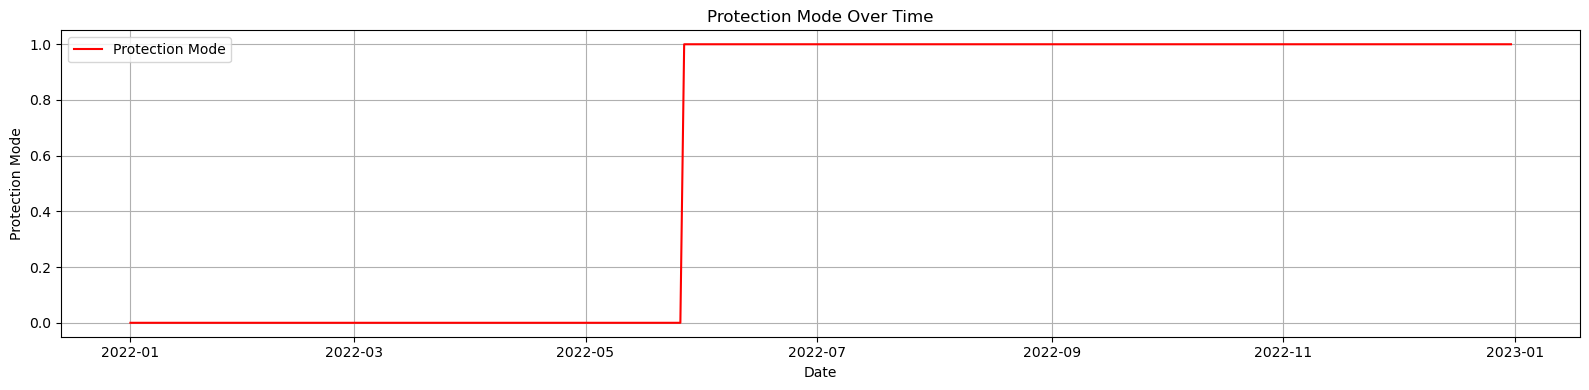

REPORT
--------------------------------
Date Range: 2022-01-01 00:00:00 - 2022-12-31 00:00:00
--------------------------------
Strategy Total Return: 42.32%
Buy and Hold Total Return: 34.63%
Strategy Improvement (%) : 22.19%
--------------------------------
Strategy Sharpe Ratio: 0.05
Buy and Hold Sharpe Ratio: 0.05
Strategy Improvement (%) : -0.01%
--------------------------------
Strategy Max Drawdown: 59.66%
Buy and Hold Max Drawdown: 66.98%
Strategy Improvement (%) : -10.94%
--------------------------------
# Buy Signals: 2
# Sell Signals: 2
# Hold Signals: 361
--------------------------------


: 

: 

In [20]:
simulate_for_year(signals_df, 2022)

## 2023


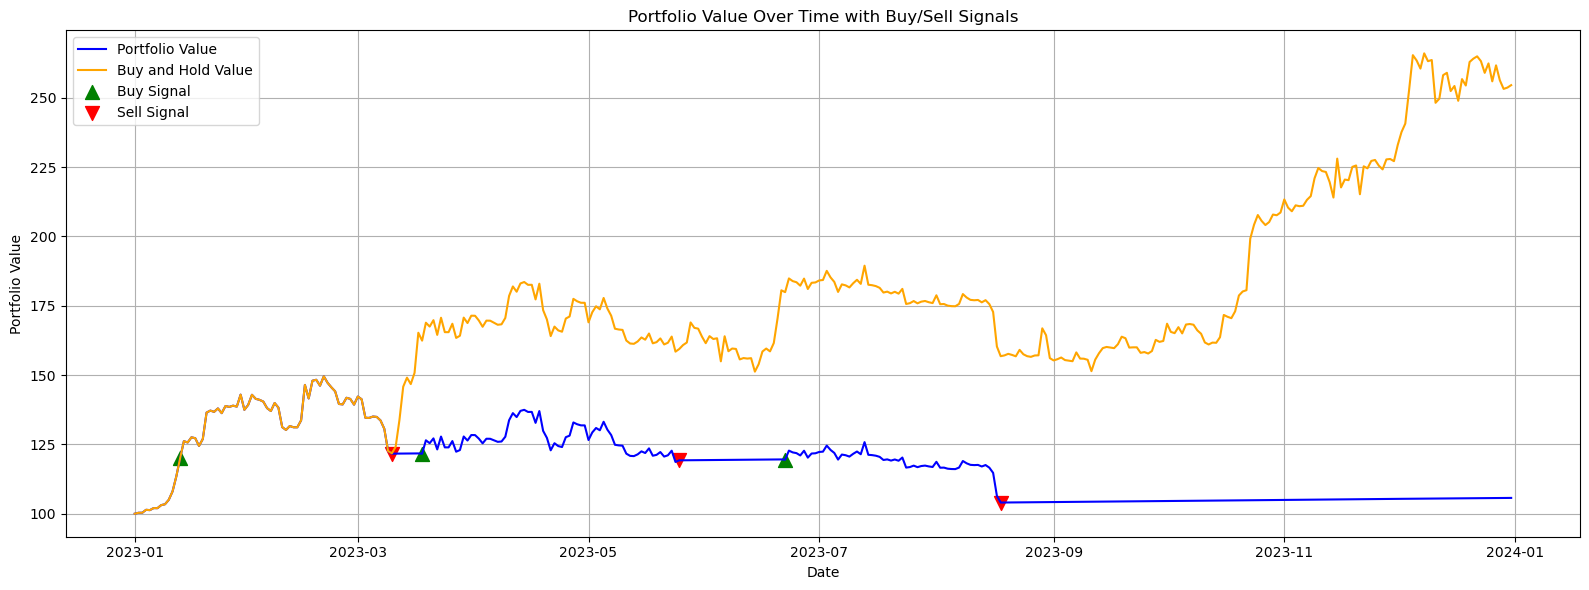

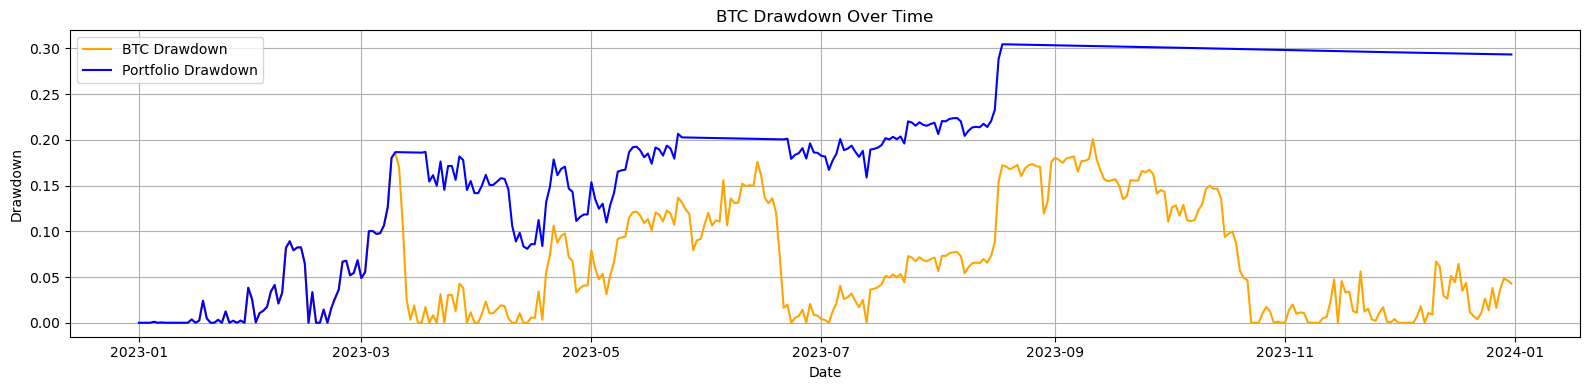

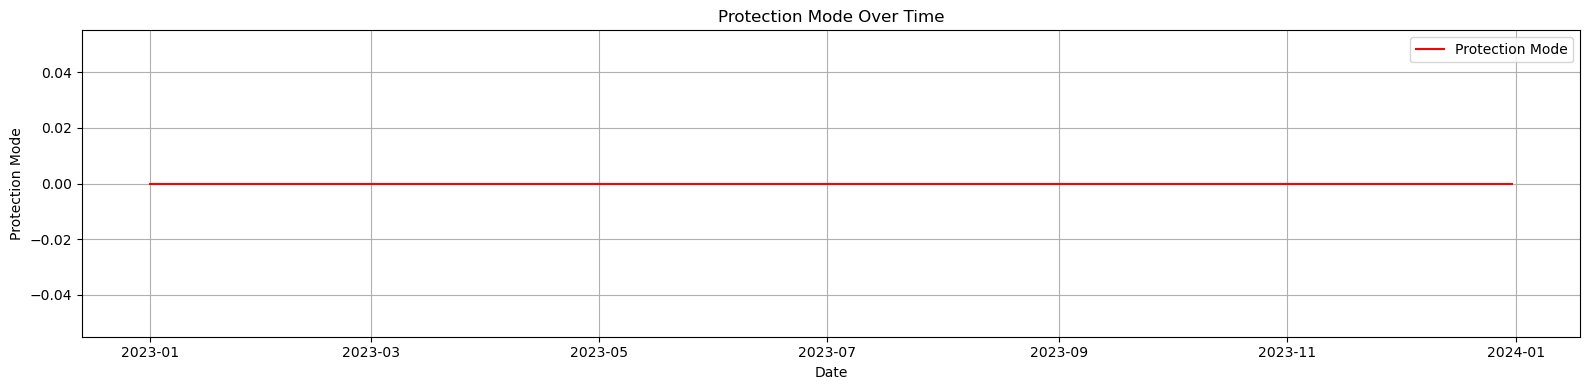

REPORT
--------------------------------
Date Range: 2023-01-01 00:00:00 - 2023-12-31 00:00:00
--------------------------------
Strategy Total Return: 105.70%
Buy and Hold Total Return: 254.57%
Strategy Improvement (%) : -58.48%
--------------------------------
Strategy Sharpe Ratio: 0.05
Buy and Hold Sharpe Ratio: 0.06
Strategy Improvement (%) : -16.57%
--------------------------------
Strategy Max Drawdown: 30.45%
Buy and Hold Max Drawdown: 20.08%
Strategy Improvement (%) : 51.63%
--------------------------------
# Buy Signals: 3
# Sell Signals: 3
# Hold Signals: 359
--------------------------------


: 

: 

In [21]:
simulate_for_year(signals_df, 2023)

## 2024


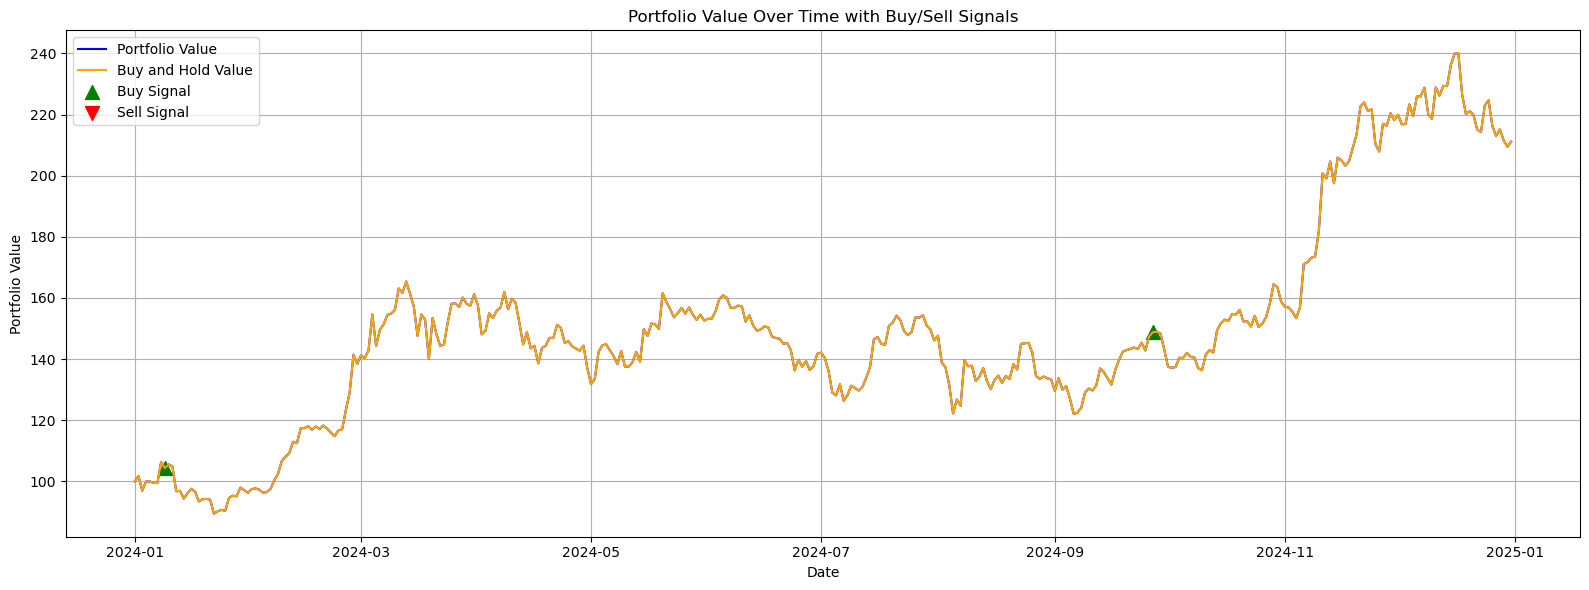

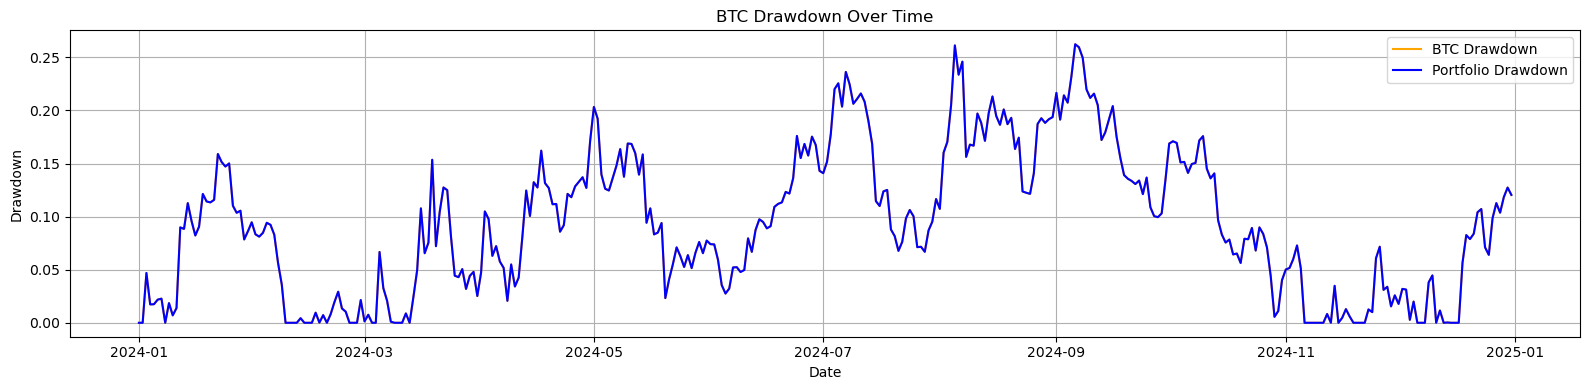

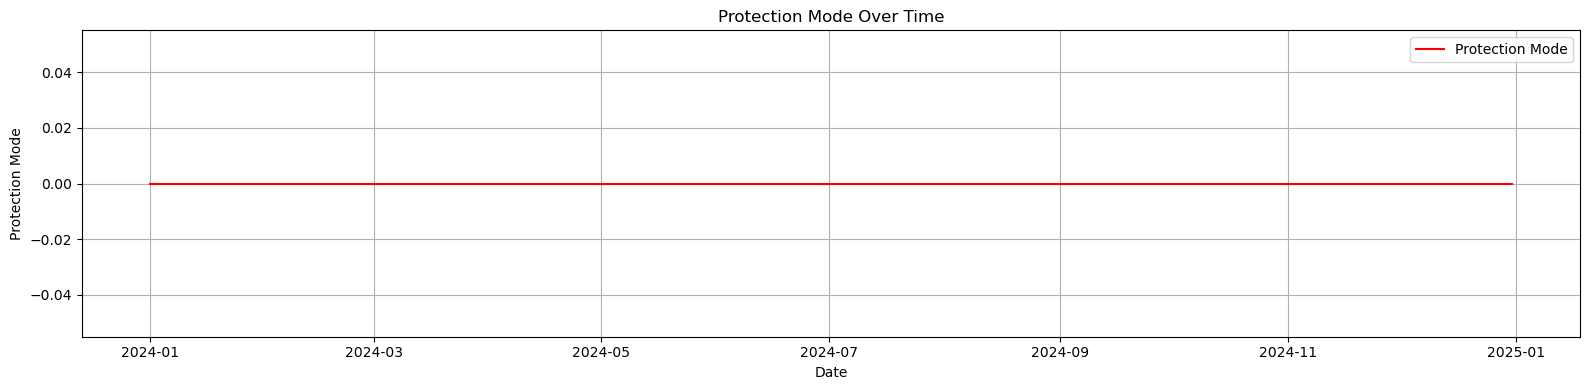

REPORT
--------------------------------
Date Range: 2024-01-01 00:00:00 - 2024-12-31 00:00:00
--------------------------------
Strategy Total Return: 211.11%
Buy and Hold Total Return: 211.11%
Strategy Improvement (%) : 0.00%
--------------------------------
Strategy Sharpe Ratio: 0.05
Buy and Hold Sharpe Ratio: 0.05
Strategy Improvement (%) : 0.00%
--------------------------------
Strategy Max Drawdown: 26.23%
Buy and Hold Max Drawdown: 26.23%
Strategy Improvement (%) : 0.00%
--------------------------------
# Buy Signals: 2
# Sell Signals: 0
# Hold Signals: 364
--------------------------------


: 

: 

In [22]:
simulate_for_year(signals_df, 2024)

## 2025

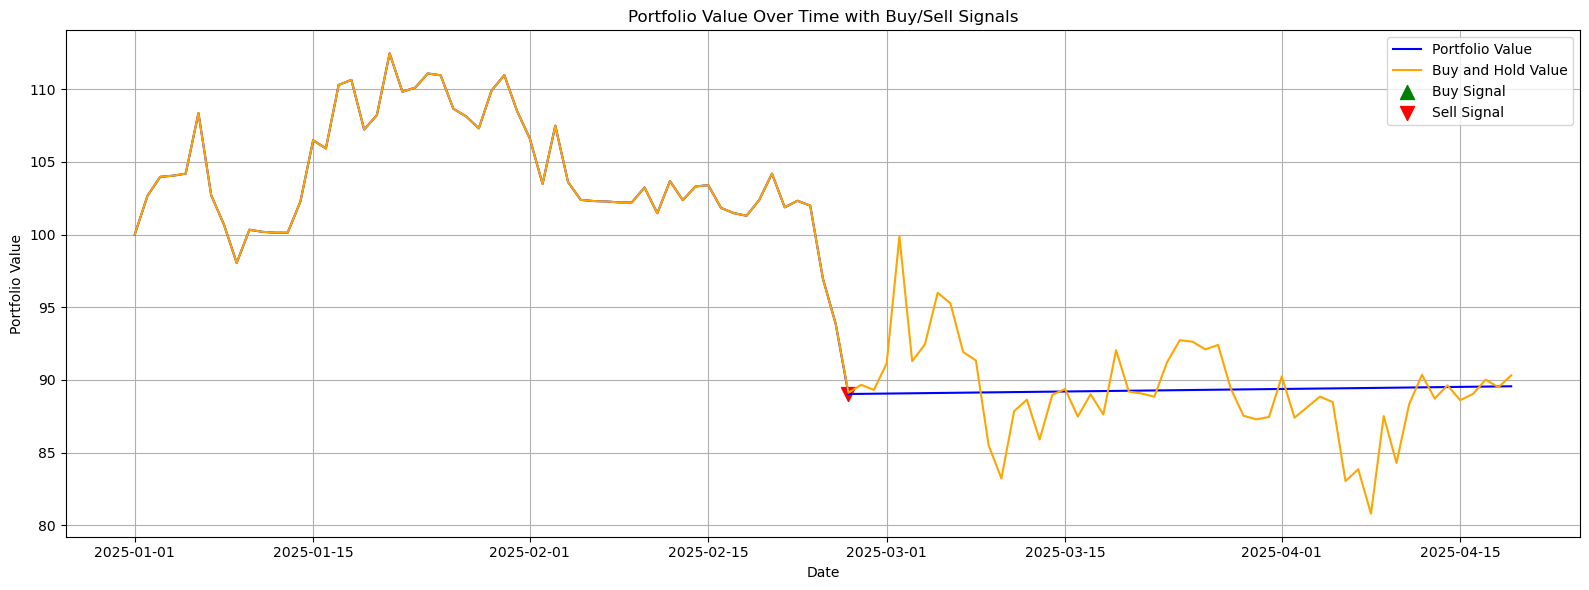

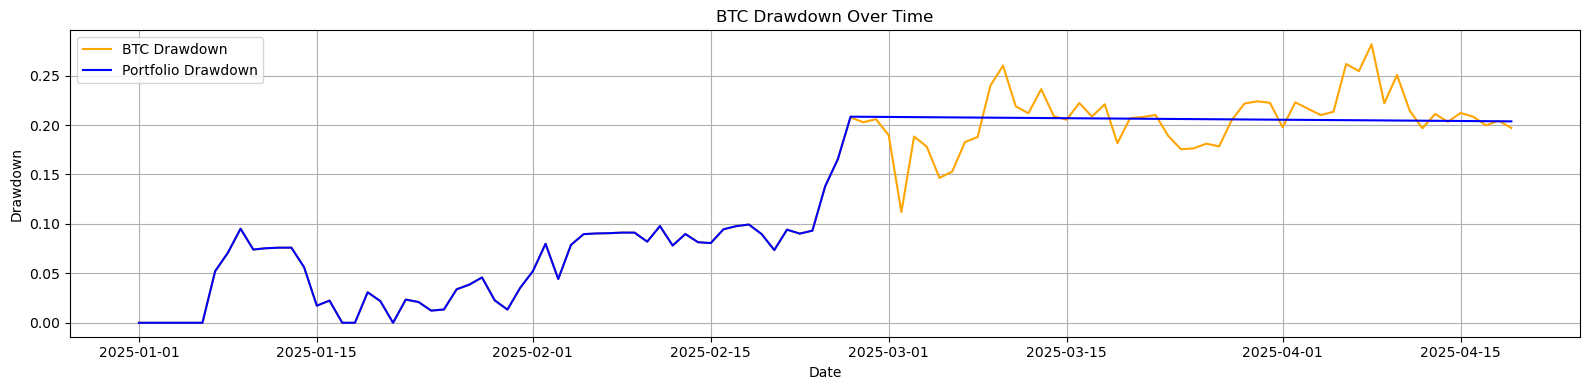

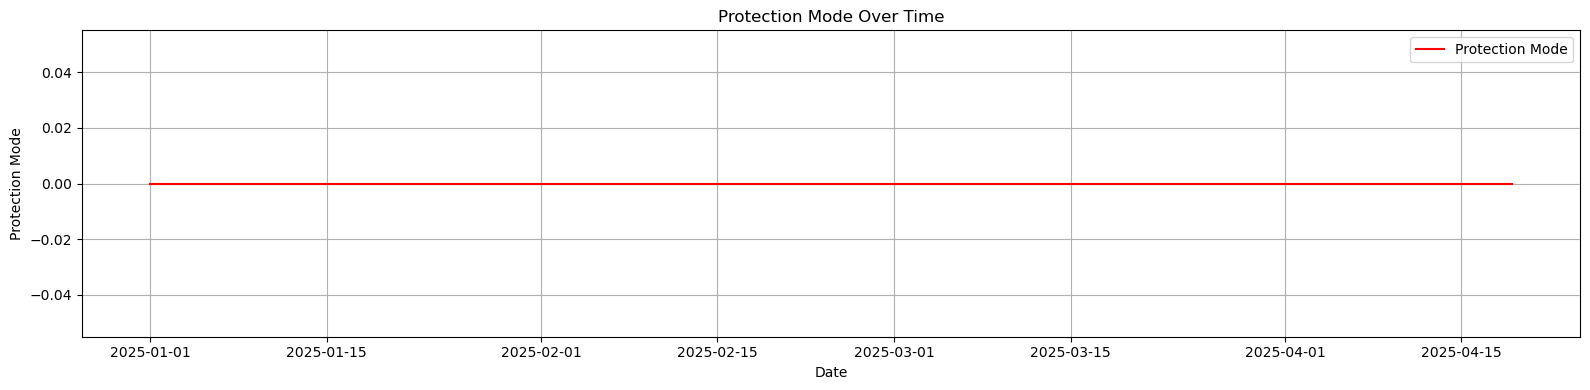

REPORT
--------------------------------
Date Range: 2025-01-01 00:00:00 - 2025-04-19 00:00:00
--------------------------------
Strategy Total Return: 89.56%
Buy and Hold Total Return: 90.31%
Strategy Improvement (%) : -0.83%
--------------------------------
Strategy Sharpe Ratio: 0.21
Buy and Hold Sharpe Ratio: 0.10
Strategy Improvement (%) : 112.96%
--------------------------------
Strategy Max Drawdown: 20.85%
Buy and Hold Max Drawdown: 28.17%
Strategy Improvement (%) : -26.00%
--------------------------------
# Buy Signals: 0
# Sell Signals: 1
# Hold Signals: 108
--------------------------------


: 

: 

In [23]:
simulate_for_year(signals_df, 2025)